In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [2]:
'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

Processing...
Done!


In [3]:
len(train_dataset)

60000

In [4]:
train_dataset[0]

(
 (0 ,.,.) = 
 
 Columns 0 to 8 
    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1176
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.1922  0.9333
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0706  0.8588
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.3137
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
   

In [5]:
train_dataset[0][0].size()

torch.Size([1, 28, 28])

In [6]:
train_dataset[0][1]

5

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [8]:
train_dataset[0][0].numpy().shape

(1, 28, 28)

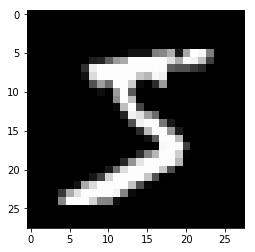

In [9]:
show_img=train_dataset[0][0].numpy().reshape(28,28)
plt.imshow(show_img,cmap='gray')

In [10]:
len(test_dataset)

10000

In [11]:
batch_size = 100
num_epochs = 20
n_iters = int((len(train_dataset) / batch_size ) * num_epochs)
n_iters 

12000

In [12]:
'''
STEP 2: MAKING DATASET ITERABLE
'''



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


### check Iterability

In [13]:
import collections
isinstance(train_loader,collections.Iterable)

True

In [14]:
'''
STEP 3: CREATE MODEL CLASS
'''
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [15]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
output_dim = 10

model = LogisticRegressionModel(input_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

'''
STEP 5: INSTANTIATE LOSS CLASS  
Note: Linear Regression: MSE. Logistic Regression: Cross Entropy Loss
CrossEntropyLoss() also doesn the softmax calculation
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.001

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Parameters In-Depth

In [16]:
print(model.parameters())
print(len(list(model.parameters())))

#FC 1 parameters
print(list(model.parameters())[0].size())
#FC 2 Bias parameters
print(list(model.parameters())[1].size())


<generator object Module.parameters at 0x127badf10>
2
torch.Size([10, 784])
torch.Size([10])


In [19]:
'''
STEP 7: TRAIN THE MODEL
'''
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
                

    # Calculate Accuracy per epoch       
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in test_loader:
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28).cuda())
        else:
            images = Variable(images.view(-1, 28*28))
        
        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        #######################
        #  USE GPU FOR MODEL  #
        #######################
        # Total correct predictions
        correct += (predicted.cpu() == labels.cpu()).sum()

    accuracy = 100 * correct / total

    # Print Loss
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.data[0], accuracy))


Epoch: 0. Loss: 1.4446109533309937. Accuracy: 76.86
Epoch: 1. Loss: 1.2490521669387817. Accuracy: 80.13
Epoch: 2. Loss: 1.156935453414917. Accuracy: 81.65
Epoch: 3. Loss: 1.158728003501892. Accuracy: 82.98
Epoch: 4. Loss: 0.9825881123542786. Accuracy: 83.63
Epoch: 5. Loss: 0.8310778141021729. Accuracy: 84.07
Epoch: 6. Loss: 0.9156706929206848. Accuracy: 84.65
Epoch: 7. Loss: 0.7972391247749329. Accuracy: 85.07
Epoch: 8. Loss: 0.7199051380157471. Accuracy: 85.49
Epoch: 9. Loss: 0.6999582052230835. Accuracy: 85.88
Epoch: 10. Loss: 0.7338166236877441. Accuracy: 86.13
Epoch: 11. Loss: 0.6606084704399109. Accuracy: 86.31
Epoch: 12. Loss: 0.5933811664581299. Accuracy: 86.49
Epoch: 13. Loss: 0.5479528903961182. Accuracy: 86.72
Epoch: 14. Loss: 0.5845401287078857. Accuracy: 86.89
Epoch: 15. Loss: 0.4874166250228882. Accuracy: 87.03
Epoch: 16. Loss: 0.5428731441497803. Accuracy: 87.19
Epoch: 17. Loss: 0.5269401669502258. Accuracy: 87.34
Epoch: 18. Loss: 0.5801512598991394. Accuracy: 87.47
Epoch